In [3]:
### Loading necessary libraries.
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source("tests.R")
source('cleanup.R')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [4]:
#reading the data
videogame <- read_csv(url("https://raw.githubusercontent.com/antaripJKashyap/DSCI100_proj/main/game_sales_data.csv"))
videogame

Rows: 19600 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Name, Platform, Publisher, Developer
dbl (5): Rank, Critic_Score, User_Score, Total_Shipped, Year

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rank,Name,Platform,Publisher,Developer,Critic_Score,User_Score,Total_Shipped,Year
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Wii Sports,Wii,Nintendo,Nintendo EAD,7.7,8.0,82.90,2006
2,Super Mario Bros.,NES,Nintendo,Nintendo EAD,10.0,8.2,40.24,1985
3,Counter-Strike: Global Offensive,PC,Valve,Valve Corporation,8.0,7.5,40.00,2012
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
19596,Ashita no Joe 2: The Anime Super Remix,PS2,Capcom,Capcom,NA,NA,0.01,2002
19597,Tokyo Yamanote Boys for V: Main Disc,PSV,Rejet,Rejet,NA,NA,0.01,2017
19598,NadePro!! Kisama no Seiyuu Yatte Miro!,PS2,GungHo,GungHo Works,NA,NA,0.01,2009


**Variables**

The main variables that will be used to make a comparison here are Critic_Score, User_Score, and Total_Shipped.

All the variables are of type double.

Critic_Score, is the average critic score awarded to this game
User_Score, is the average user score awarded by the people who bought and played this game
The above two variables wont explicitly be used in all cases
Instead for cases where both critic score and user score are present, we will combine them to a Weighted Score, which will be a weighted average of the two.
Total_Shipped, is the total units sold in millions. So 82.90 refers to 82.9 million units sold

The Data appears to be tidy with variables in their own column

**Excluded variables**

Rank (double)= Simply arranges all the data in descending order of Total_Shipped, not necessary to make any predictions for Total_shipped
Name (Char)= Is the name of the product. It is excluded as we are not doing a classification problem but instead a reggression problem trying to predict the Total_Shipped
Platform(Char) = Platform that the game was released for. Not necessary to make any predictions
Publisher and Developer (both Char)= Both these variables usually have no bearing on the critic score, but do occasionally have a bearing on the total copies sold due to popularity, however, since we are doing a regression problem, they cannot help us in their predictive capacity.


In [5]:
quantile(videogame$Total_Shipped)
IQR(videogame$Total_Shipped)
upper <- 0.46 + 1.5*0.41
lower <- 0.05 - 1.5*0.41
upper
lower

0%   25%   50%   75%  100% 
 0.01  0.05  0.16  0.46 82.90

[1] 0.41

[1] 1.075

[1] -0.565

In [29]:
#tidying the data to display predictive capabilities
videogame_combined <- videogame |>
    group_by(User_Score,Critic_Score) |>
    mutate(Weighted_Score = ifelse(User_Score != "NA" && Critic_Score != "NA", (User_Score + Critic_Score)/2, 
        ifelse(User_Score == "NA" && Critic_Score != "NA", Critic_Score, 
            ifelse(User_Score != "NA" && Critic_Score == "NA", User_Score, NA)))) |>
    select(Rank, Name, Platform, Critic_Score, User_Score, Total_Shipped, Weighted_Score) |>
#we filter out all the outliers computed by (3rd Quartile + 1.5 * IQR) and (1st Quartile - 1.5 * IQR)
    filter(Total_Shipped < 1.075)
videogame_combined


#trying to determine if there is a difference in platform for the average scores, and the average sales
videogame_summaries <- videogame_combined |>
    group_by(Platform) |>
    summarize(avg_critic = mean(Critic_Score, na.rm = TRUE),
              avg_user = mean(User_Score, na.rm = TRUE),
              avg_shipped = mean(Total_Shipped)) |>
    arrange(desc(avg_shipped))

videogame_summaries


Rank,Name,Platform,Critic_Score,User_Score,Total_Shipped,Weighted_Score
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2254,LEGO Star Wars II: The Original Trilogy,DS,4.9,NA,1.07,NA
2255,Marvel vs. Capcom 3: Fate of Two Worlds,X360,8.4,NA,1.07,NA
2256,Doko Demo Issyo,PS,NA,NA,1.07,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮
19596,Ashita no Joe 2: The Anime Super Remix,PS2,NA,NA,0.01,NA
19597,Tokyo Yamanote Boys for V: Main Disc,PSV,NA,NA,0.01,NA
19598,NadePro!! Kisama no Seiyuu Yatte Miro!,PS2,NA,NA,0.01,NA


Platform,avg_critic,avg_user,avg_shipped
<chr>,<dbl>,<dbl>,<dbl>
NES,7.166667,NaN,0.6624138
GBC,NaN,NaN,0.5600000
2600,NaN,NaN,0.4377064
⋮,⋮,⋮,⋮
3DO,NaN,NaN,0.0475
Mob,NaN,NaN,0.0300
PCFX,NaN,NaN,0.0300


In [6]:
test <- videogame |>
    # group_by(Critic_Score, User_Score) |>
    mutate(Weighted_Score = ifelse(!is.na(User_Score) && !is.na(Critic_Score), ((User_Score + Critic_Score)/2), 
        ifelse(is.na(User_Score) && !is.na(Critic_Score), Critic_Score, 
            ifelse(!is.na(User_Score) && is.na(Critic_Score), User_Score, NA))))


test[2256, ]
       
test

Rank,Name,Platform,Publisher,Developer,Critic_Score,User_Score,Total_Shipped,Year,Weighted_Score
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2254,LEGO Star Wars II: The Original Trilogy,DS,LucasArts,Amaze Entertainment,4.9,NA,1.07,2006,7.85


Rank,Name,Platform,Publisher,Developer,Critic_Score,User_Score,Total_Shipped,Year,Weighted_Score
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Wii Sports,Wii,Nintendo,Nintendo EAD,7.7,8.0,82.90,2006,7.85
2,Super Mario Bros.,NES,Nintendo,Nintendo EAD,10.0,8.2,40.24,1985,7.85
3,Counter-Strike: Global Offensive,PC,Valve,Valve Corporation,8.0,7.5,40.00,2012,7.85
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
19596,Ashita no Joe 2: The Anime Super Remix,PS2,Capcom,Capcom,NA,NA,0.01,2002,7.85
19597,Tokyo Yamanote Boys for V: Main Disc,PSV,Rejet,Rejet,NA,NA,0.01,2017,7.85
19598,NadePro!! Kisama no Seiyuu Yatte Miro!,PS2,GungHo,GungHo Works,NA,NA,0.01,2009,7.85


In [35]:
#splitting data into training and testing with the training split having 75% of the data
videogame_split <- initial_split(videogame_combined, prop= 0.75, strata= Weighted_Score)
videogame_train <- training(videogame_split)
videogame_test <- testing(videogame_split)

Warning message:
“Removed 11742 rows containing missing values (geom_point).”


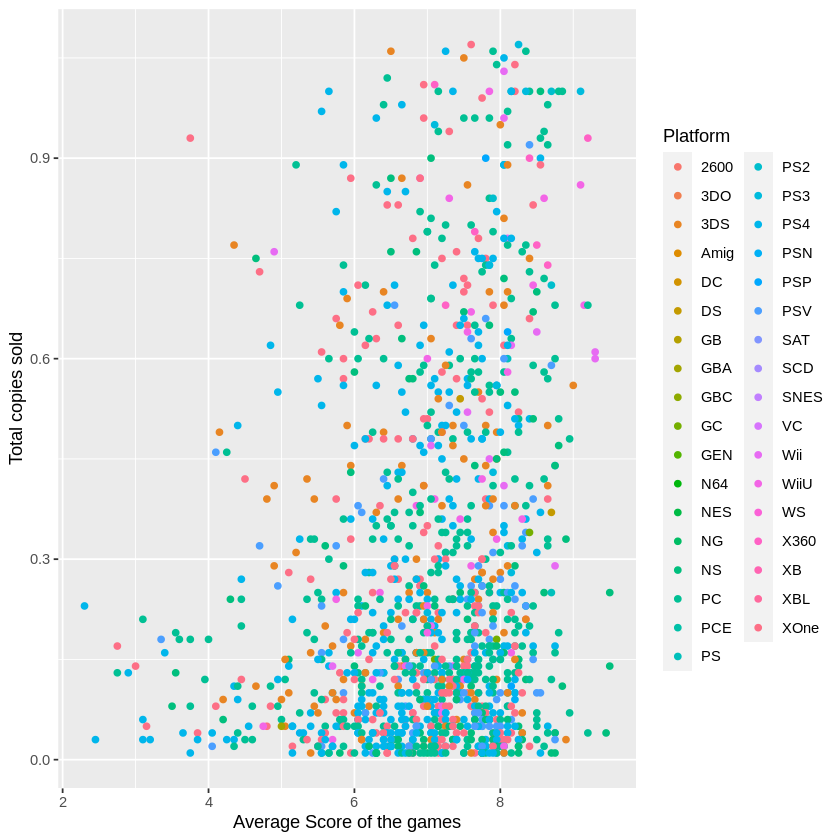

In [39]:
videogame_plot <- ggplot(videogame_train, aes(x= Weighted_Score, y= Total_Shipped, colour = Platform)) +
geom_point() + labs(x= "Average Critic Score of the games", y= "Total copies sold")
videogame_plot